# Convolutuinal Neural Networks With Dataset
Now it's time to talk about convolutional neural networks and in this notebook you will find out how to the dataset library to do:
* data augmentation
* early stopping
* learning rate decay.

In this example the [batch class](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/Second_tutorial/my_batch.py) and the [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/Second_tutorial/simple_conv_model.py) are used.

In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../..')

import utils
from my_batch import MnistBatch
from simple_conv_model import ConvModel

from dataset import B,V,F
from dataset.opensets import MNIST

Instead of generating data, you can implement a basic batch class with preloaded [MNIST](https://analysiscenter.github.io/dataset/api/dataset.opensets.html#mnist) dataset.

In [2]:
mnist = MNIST(batch_class=MnistBatch)

ExtractingExtracting /tmp/train-images-idx3-ubyte.gz
 Extracting /tmp/train-labels-idx1-ubyte.gzExtracting/tmp/t10k-images-idx3-ubyte.gz
 
/tmp/t10k-labels-idx1-ubyte.gz


As we already learned from the [first task](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/First_tutorial/Dataset.ipynb), first of all you have to define config and create train and test pipelines. 

Let's create a config for a model. If you open the file with the [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/Second_tutorial/simple_conv_model.py) you can see [__default_config__](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.base.TFModel.default_config). It is a function, that llows to add the default configuration to the model.

But if you want to override default config you can add parameters in model config. For example:

ConvModel has dict __config__ with key __'body'__. You can override it by adding in __model_config__ key __'body'__ with dict of parameters of body function (as in [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/Second_tutorial/simple_conv_model.py) file). 

Or add useful params by typing in a __model_config__ key like __'body/layout'__ and params to this key. Similar way use it in the key __'input_block/inputs'__ or __'head/units'__.

Models are split in three parts:
* __input_block__ - block containing the input layers.
* __body__ - the main part of the model
* __head__ - outputs layers, like global average pooling or dense layers.

In [3]:
model_config = {
    'inputs': dict(images={'shape': (28, 28, 1)},
                   labels={'classes': (10), 
                           'transform': 'ohe', 
                           'name': 'targets'}),
    'loss': 'softmax_cross_entropy',
    'decay': ('exp', {'learning_rate': 0.001,
                      'decay_steps': 150,
                      'decay_rate': 0.96}),
    'optimizer': 'RMSProp',
    'input_block/inputs': 'images',
    'head/units': 10,
    'output': dict(ops=['labels', 'proba', 'accuracy'])
}

And don't forget about feed dict

In [4]:
data_dict = {
    'images': B('images'),
    'labels': B('labels')
}

When config is defined, next step is to create a pipeline.Note that __random_rotate__ and __random_scale__ are methods of the __ImagesBatch__ class(parent of our class). You can see all avalible augmentations in [examples](https://github.com/analysiscenter/dataset/blob/master/examples/simple_but_ugly/image_basic.py) for the Dataset.

In contrast to them __shift_flattned_pic__ is a function from [my_batch](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/Second_tutorial/my_batch.py). It is worth mentioning because it runs in parallel. About parallel method read [docs](https://analysiscenter.github.io/dataset/intro/parallel.html).

In [5]:
train_pipeline = (mnist.train.p
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True)
                 .random_scale(p=.8, factor=(.7, 1.3)) 
                 .init_variable('train_accuracy', init_on_each_run=list)
                 .init_model('dynamic',
                             ConvModel,
                             'conv',
                              config=model_config)
                 .train_model('conv',
                              fetches='accuracy',
                              feed_dict=data_dict,
                              save_to=V('train_accuracy'), mode='a'))

And test on the augmented data

In [6]:
test_pipeline = (mnist.test.p
                 .import_model('conv', train_pipeline)
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True)
                 .random_scale(p=.8, factor=(.7, 1.3))
                 .init_variable('test_accuracy', init_on_each_run=list)
                 .predict_model('conv', 
                             fetches='accuracy',
                             feed_dict=data_dict,
                             save_to=V('test_accuracy'), mode='a'))

We introduce early stopping to terminate the model when average accuracy in 'window' epochs will be more than 0.95 percent

In [7]:
MAX_ITER = 700
window = 50
average = [0]
batch_size = 100

for curr_iter in tqn(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size, n_epochs=None)
    test_pipeline.next_batch(batch_size, n_epochs=None)

    if curr_iter % window == 0:
        average.append(np.mean(test_pipeline.get_variable('test_accuracy')[curr_iter - window:]))

    #Early stopping   
    if average[-1] > 0.95:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

Widget Javascript not detected.  It may not be installed or enabled properly.


Now we predict image class on test data and draw accuracy graph

../../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


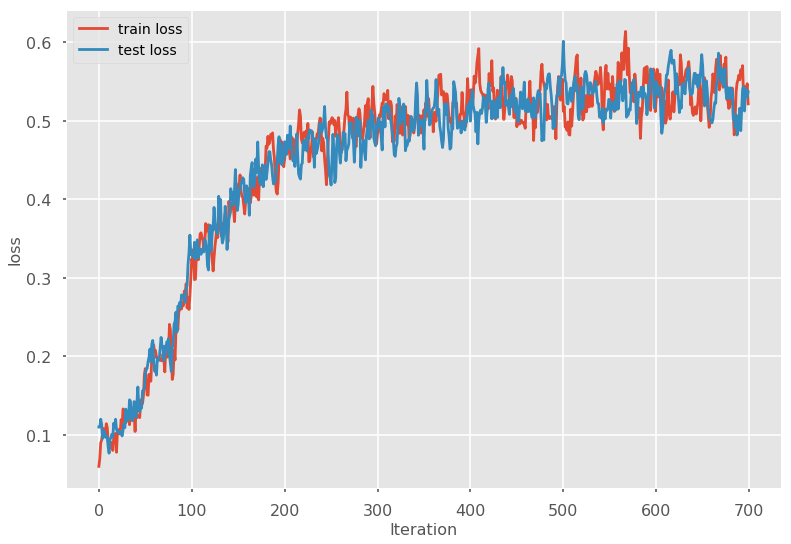

In [8]:
train_accuracy = train_pipeline.get_variable('train_accuracy')
test_accuracy = test_pipeline.get_variable('test_accuracy')
utils.draw(train_accuracy,'train', test_accuracy, 'test', 'loss')

Accuracy graph is probably good, but what about real predictions?

In [9]:
validation_pipeline = (mnist.test.p
                       .import_model('conv', train_pipeline)
                       .shift_flattened_pic()
                       .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True)
                       .random_scale(p=.8, factor=(.7, 1.3))
                       .init_variable('answers', init_on_each_run=list)
                       .init_variable('img', init_on_each_run=list)
                       .init_variable('predict', init_on_each_run=list)
                       .init_variable('prob', init_on_each_run=list)
                       .predict_model('conv', 
                                      fetches=['labels', 
                                               'images', 
                                               'predicted_labels', 
                                               'predicted_proba'],
                                      feed_dict=data_dict,
                                      save_to=[V('answers'),
                                               V('img'), 
                                               V('predict'), 
                                               V('prob')],
                                      mode='a'))

It's always interesting to look at the images, so let's draw them.

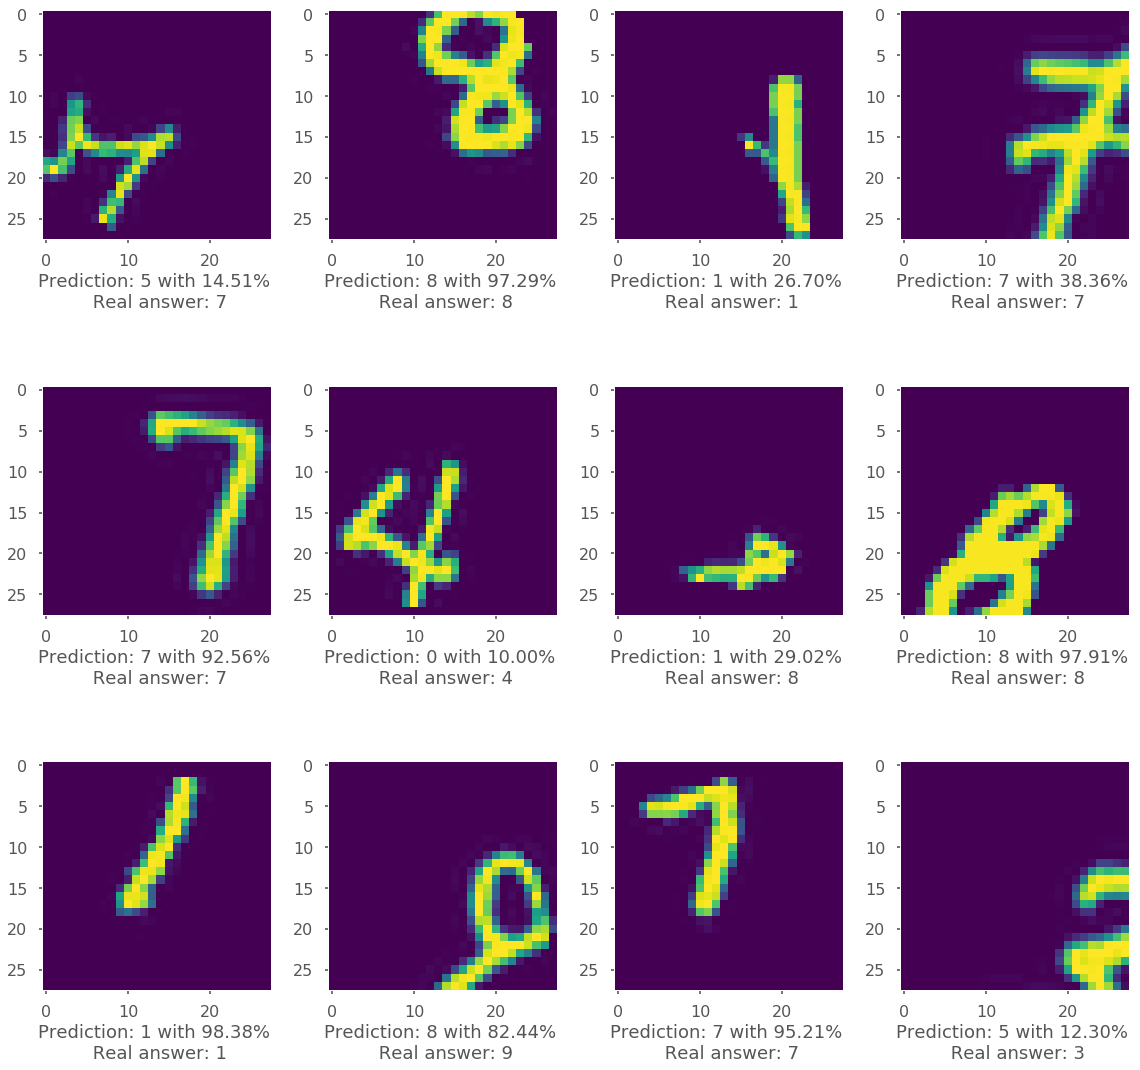

In [10]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)


for num_batch in range(12):
    validation_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    answer= validation_pipeline.get_variable('answers')
    img = validation_pipeline.get_variable('img')
    predict = validation_pipeline.get_variable('predict')
    prob = validation_pipeline.get_variable('prob')
    ax[num_batch].imshow(img[-1].reshape(-1, 28))
    ax[num_batch].set_xlabel('Prediction: {} with {:.2f}% \n Real answer: {}'\
                             .format(predict[-1][0],
                             prob[-1][0] \
                             [np.argmax(prob[-1])]*100, \
                             answer[-1][0]),\
                             fontsize=18)
    ax[num_batch].grid()
plt.tight_layout(pad=0.4, w_pad=0., h_pad=1.0)
plt.show()

# Conclusion
* Today you got acquainted with convolutional neural network and how to create one within the dataset.
* You know how to easily load MNIST data without writing your own loading functions.
* How to perforn data augmentation with dataset.
* Get to know how to configure the model using model config.
* Find out that network can learn data augmentations (like scale and rotate). 

### And what's next?
Because you know how to configure convolution model, you can create:
* model with MNIST 3-channels data, instead 1 in our example.
* config to our model, with own parameters of the network. Your goal is 0.95 on the test data!
Good luck!


In our next notebook, we will try to find out what is best ResNet34 or ResNet50. Interested? [Click](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/Third_tutorial/Models.py).